In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed = 42
import torch
from create_dataset import *
from torch.utils.data import Dataset, DataLoader

'''
    This cell is required since I messed around with pickle module while serializing data. Sorry for that.
'''
import sys, types
sys.modules['dataset'] = types.ModuleType('dataset')
sys.modules['dataset.map_sample'] = types.ModuleType('map_sample')
sys.modules['dataset.map_sample'].__dict__['MapSample'] = MapSample
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load data and sync with game

In [2]:
map_dataset = torch.load('/home/meiri.yoav/cogrob_project/maps_dataset.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_size = int(0.8 * len(map_dataset))
test_size = len(map_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(map_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True, collate_fn=custom_collate_fn)

cuda


In [3]:
print(len(map_dataset)) # Generating 10,000 maps: 9.5 hours

37770


In [4]:
sample_example = map_dataset[8][0]
print('Map:')
print(sample_example.map.to(int).tolist())
print('Path:')
print(sample_example.path.to(int).tolist())
print('Start:')
print(sample_example.start.to(int).tolist())
print('Goal:')
print(sample_example.goal.to(int).tolist())

goal_tensor = torch.zeros_like(sample_example.map, dtype=sample_example.map.dtype)
goal_tensor[sample_example.goal[0], sample_example.goal[1]] = 1
goal_tensor

Map:
[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Arranging data for CNN training

In [12]:
import torch.nn as nn   
from torch.nn import Conv2d, ReLU, Module, ModuleList

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, stride=1, dilation=1, padding=1)
        self.relu = ReLU()
        self.batchnorm = nn.BatchNorm2d(outChannels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        return self.pool(self.batchnorm(self.relu(self.conv1(x))))

class distancer(nn.Module):
    def __init__(self):
        super(distancer, self).__init__()

        self.first_layer = Block(2, 64)
        self.mid_conv_layers = []
        for i in range(1):
            self.mid_conv_layers.append(Block(64, 64))
        
        self.last_layer = Block(64, 16)
        self.mid_conv_layers = ModuleList(self.mid_conv_layers)
        self.fc = nn.Sequential(nn.Linear(12*12*16, 50*100), nn.ReLU(), nn.Linear(100*50, 100*100), nn.ReLU())

    def forward(self, x):
        x = self.first_layer(x)
        for layer in self.mid_conv_layers:
            x = layer(x)
        
        x = self.last_layer(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = x.reshape(x.shape[0], 1, 100, 100)
        return x

In [13]:
import seaborn as sns

def vis_grid(grid, title=None, save=None):
    plt.figure(figsize=(5,5))
    g = sns.heatmap(grid, annot=False, fmt=".2f", cmap="magma", cbar=True, square=True)
    g.tick_params(left=False, bottom=False)
    g.set(xticklabels=[], yticklabels=[])
    if title != None:
        plt.title(title)
    if save != None:
        plt.savefig(save)
    plt.show()

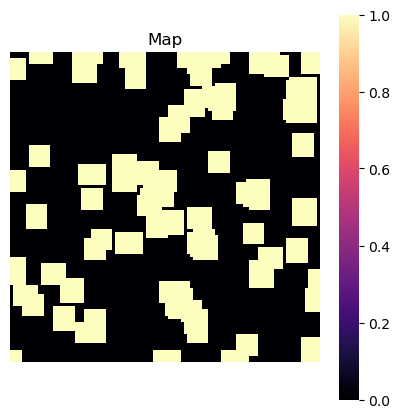

In [14]:
vis_grid(sample_example.map.to(int).tolist(), title='Map')

In [15]:
from tqdm import tqdm
import torch.optim as optim
torch.set_printoptions(profile="full")

epoch_num = 40

model = distancer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def forward_loader(loader, model, criterion, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()
        
    total_loss = 0
    for maps, starts, goals, goals_tensors, dist_tensors, paths in loader:
        goals_tensors = goals_tensors.unsqueeze(1)

        X = torch.cat((maps, goals_tensors), dim=1).to(device)
        y = dist_tensors.to(device)
        # y = paths.to(device)

        pred = model(X)
        
        optimizer.zero_grad()
        
        obstacle_mask = (torch.ones(maps.shape).to(device) - maps).squeeze()
        loss = criterion(torch.mul(pred.squeeze(),obstacle_mask), y.float())
        
        total_loss += loss.item()
        if train:
            loss.backward()
            optimizer.step()
    return total_loss / len(loader)

train_loss = []
test_loss = []
train_loss.append(forward_loader(train_loader, model, criterion, optimizer, train=False))
test_loss.append(forward_loader(test_loader, model, criterion, optimizer, train=False))
print(f'Epoch [0/{epoch_num}] | train loss: {train_loss[-1]} test loss: {test_loss[-1]}')

for epoch in range(1, epoch_num):
    train_loss.append(forward_loader(train_loader, model, criterion, optimizer, train=True))
    test_loss.append(forward_loader(test_loader, model, criterion, optimizer, train=False))
    if epoch % 4 == 0:
        print(f'Epoch [{epoch}/{epoch_num}] | train loss: {train_loss[-1]} test loss: {test_loss[-1]}')

Epoch [0/40] | train loss: 5569.791520854856 test loss: 5609.053071674548
Epoch [4/40] | train loss: 117.02492631644257 test loss: 103.65785834663792
Epoch [8/40] | train loss: 39.01890034005662 test loss: 47.943091317227015
Epoch [12/40] | train loss: 18.89474260472069 test loss: 33.91995493361824
Epoch [16/40] | train loss: 12.467355720267808 test loss: 32.16603991859838
Epoch [20/40] | train loss: 10.20964917427252 test loss: 31.66598077196824
Epoch [24/40] | train loss: 8.764485800561825 test loss: 30.77275414215891
Epoch [28/40] | train loss: 7.9017281492879565 test loss: 30.24596717483119
Epoch [32/40] | train loss: 7.1539661202548945 test loss: 29.317880015624198
Epoch [36/40] | train loss: 6.690236680369732 test loss: 29.41452904124009


In [23]:
torch.save(model.state_dict(), '25-3-model.pkl')

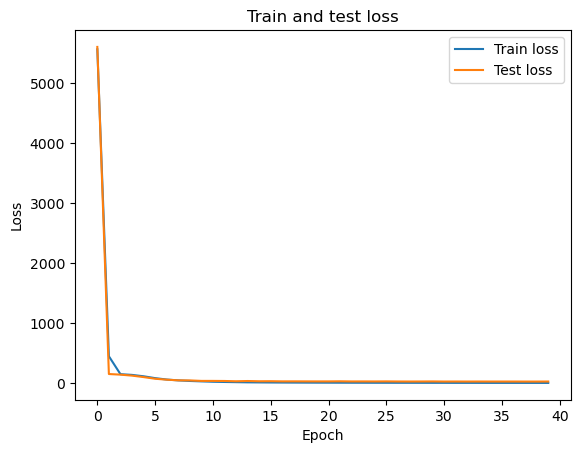

In [19]:
# Create Train and test loss graph  
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.title('Train and test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

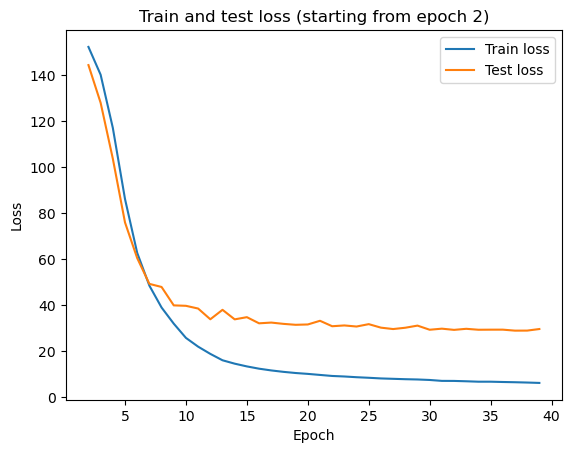

In [21]:
# Create Train and test loss graph starting from epoch 4
starting_epoch = 2
epoch_num = 40
plt.plot(range(starting_epoch, epoch_num), train_loss[starting_epoch:], label='Train loss')
plt.plot(range(starting_epoch, epoch_num), test_loss[starting_epoch:], label='Test loss')
plt.title(f'Train and test loss (starting from epoch {starting_epoch})')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.show()


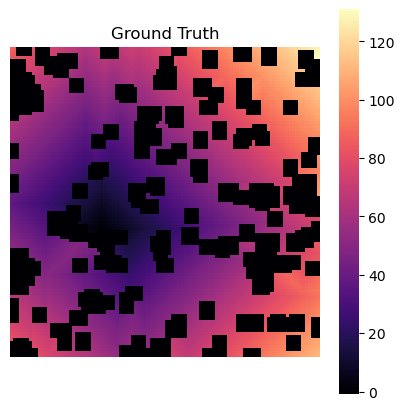

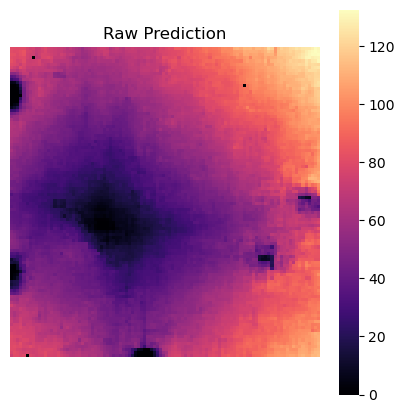

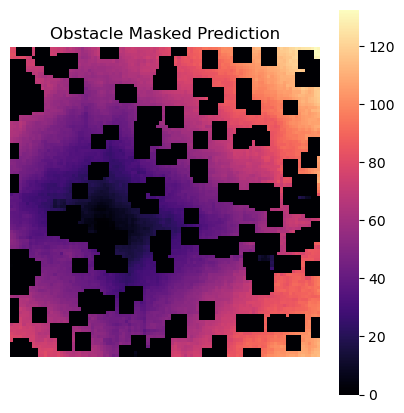

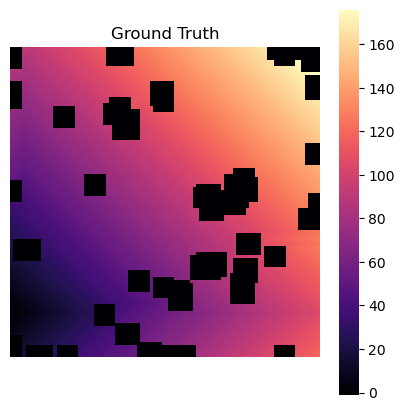

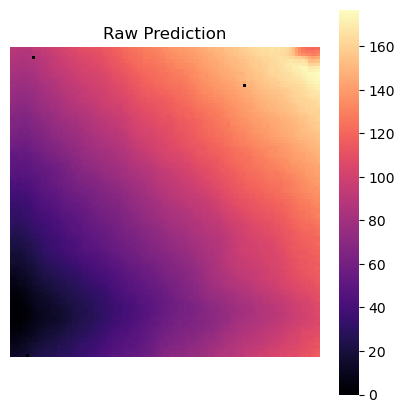

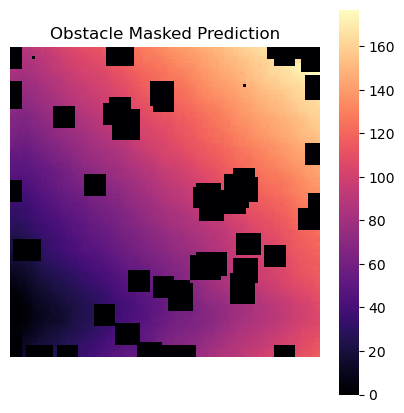

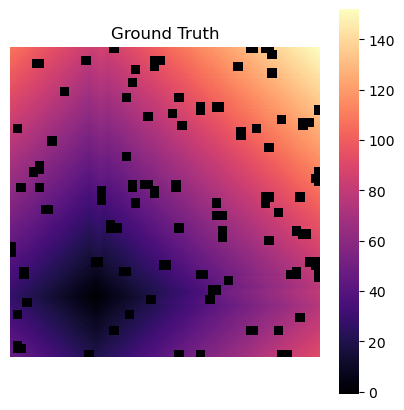

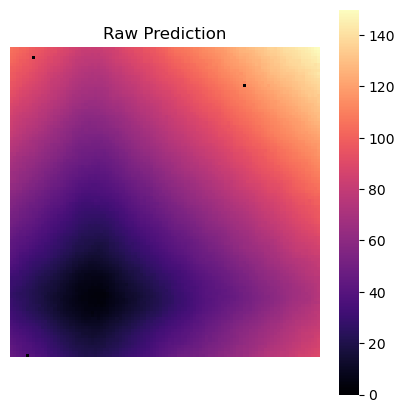

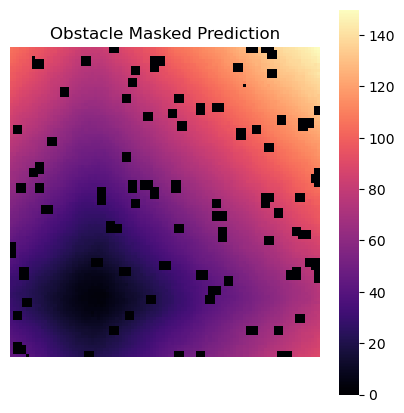

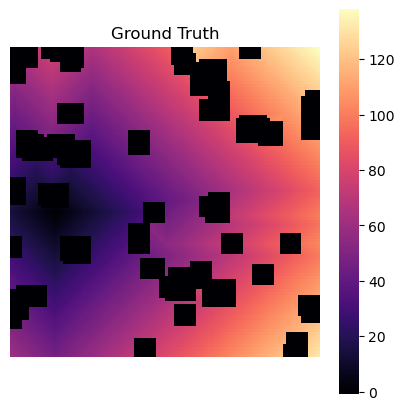

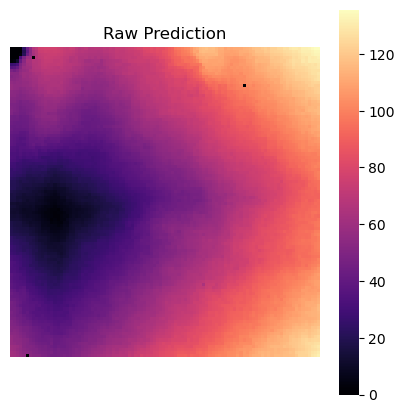

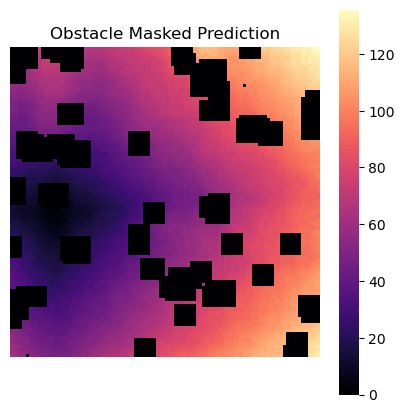

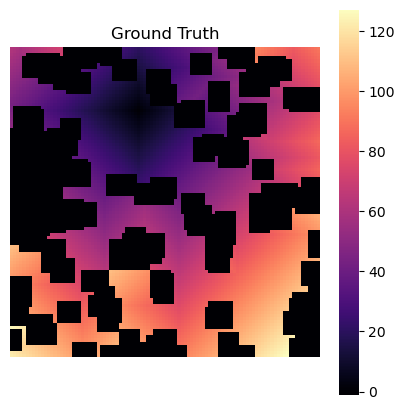

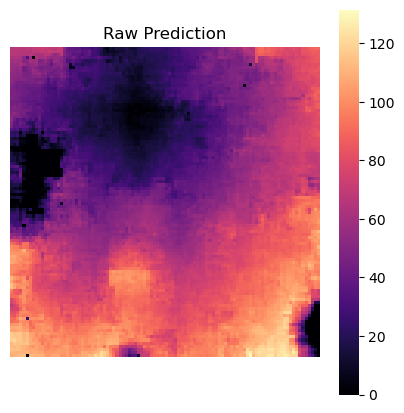

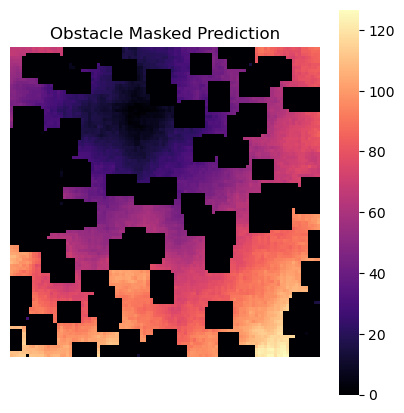

In [22]:
samples_printed = 4
for maps, starts, goals, goals_tensors, dist_tensors, paths in train_loader:
    model.eval()
    goals_tensors = goals_tensors.unsqueeze(1)

    start_tensor = torch.zeros(goals_tensors.shape)
    for i in range(start_tensor.shape[0]):
        start_tensor[i][0][starts[i]] = 1
        
    X = torch.cat((maps, goals_tensors), dim=1).to(device)
    y = dist_tensors.to(device)

    vis_grid(y[0].tolist(), title="Ground Truth", save=f'imgs_25_3/Ground_Truth_{samples_printed}.png')
    vis_grid(model(X)[0][0].tolist(), title="Raw Prediction", save=f'imgs_25_3/Raw_Prediction_{samples_printed}.png')
    vis_grid((torch.mul(model(X)[0][0], torch.ones(maps[0][0].shape).to(device) - maps[0][0])).tolist(), title="Obstacle Masked Prediction", save=f'imgs_25_3/Obstacle_Masked_Prediction_{samples_printed}.png')
    # single_map = maps[0][0]
    # print(single_dists.shape)
    if samples_printed == 0:
        break
    samples_printed -= 1

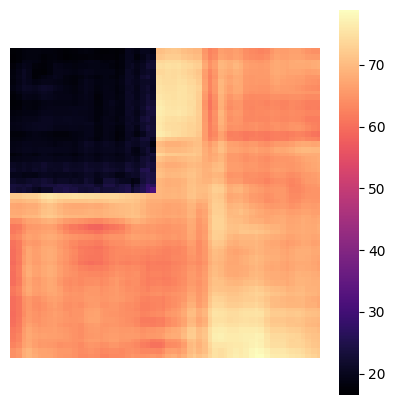

In [34]:
vis_grid(single_pred.tolist())

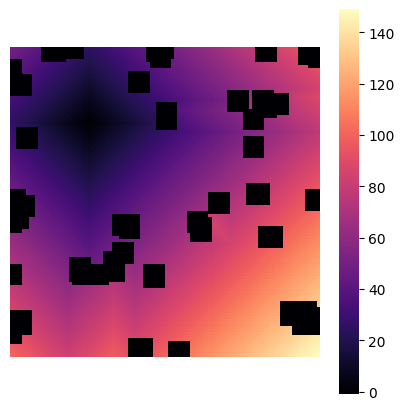

In [35]:
vis_grid(single_dists.tolist())

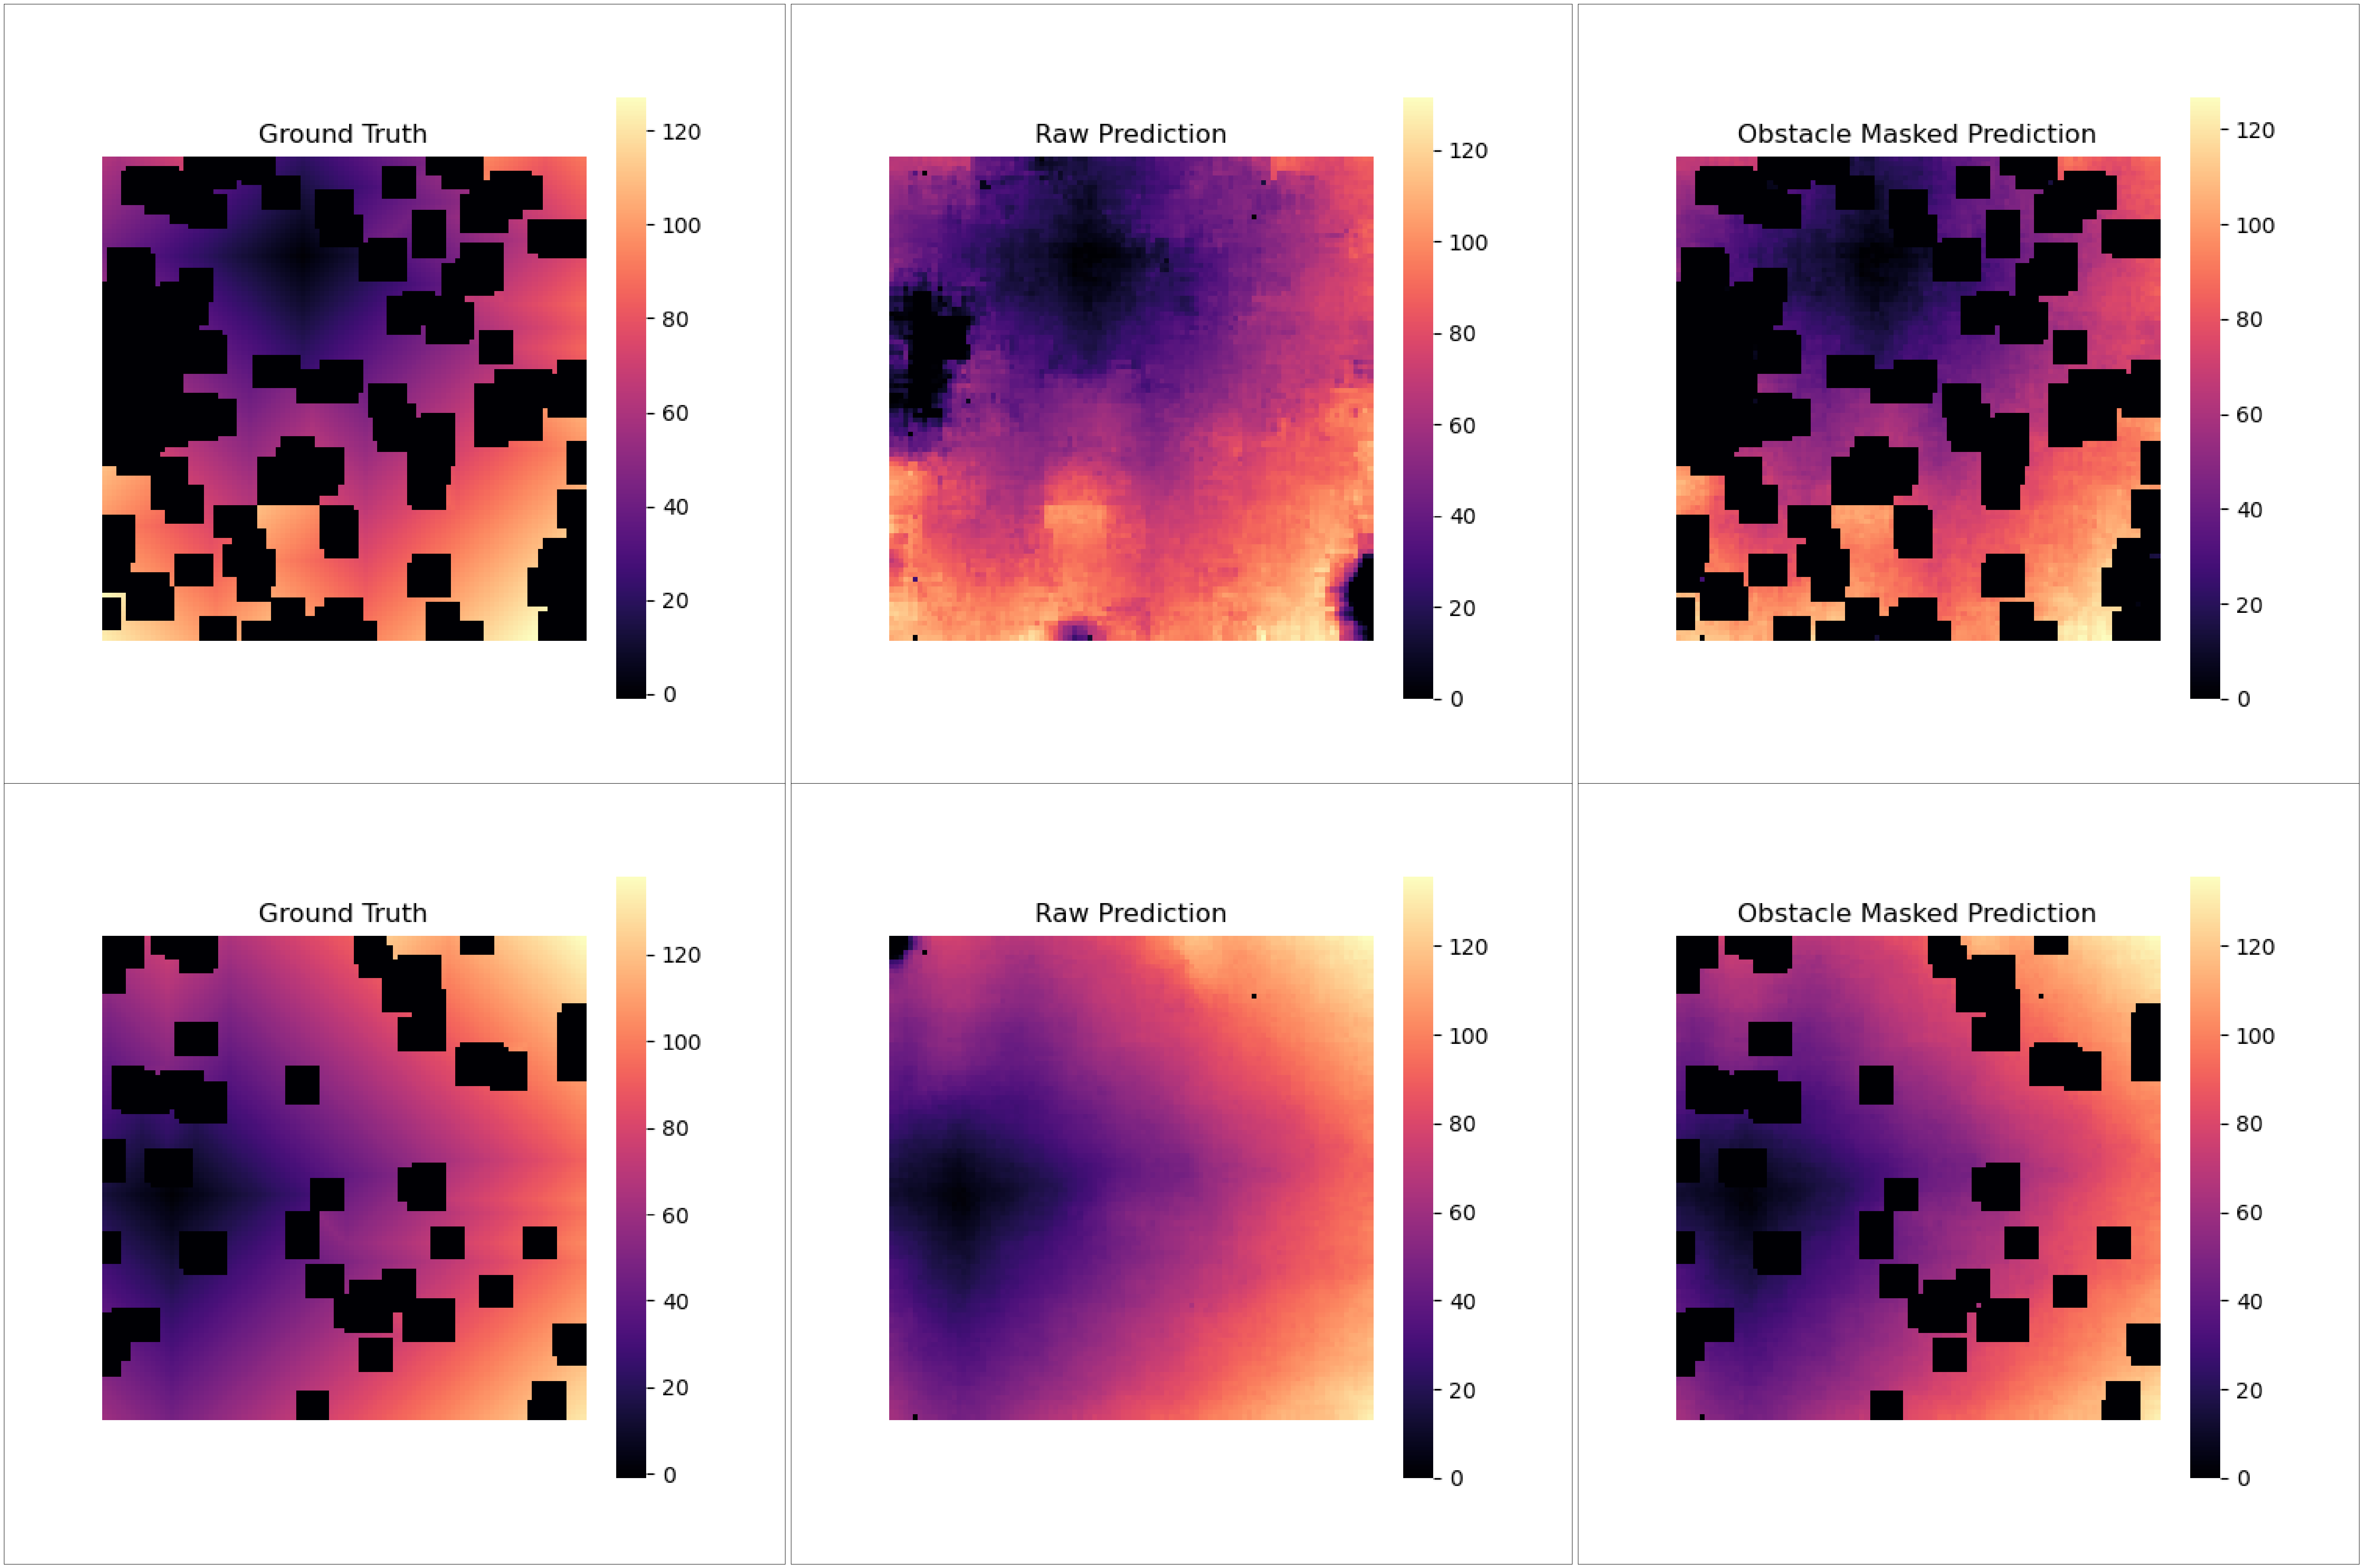

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(60, 40), sharey=True)

for i in range(2):
    
    j = 0
    image = plt.imread(f'imgs_25_3/Ground_Truth_{i}.png')
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].imshow(image)
    
    j = 1
    image = plt.imread(f'imgs_25_3/Raw_Prediction_{i}.png')
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].imshow(image)
    
    j = 2
    image = plt.imread(f'imgs_25_3/Obstacle_Masked_Prediction_{i}.png')
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].imshow(image)

fig.tight_layout()
plt.show()